# Figure 6

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pencil_old as pc

In [13]:
def scale_height(c_s, omega):
    return c_s / omega

def sound_speed(T):
    R_GAS = 8.314e7  # The gas constant
    GAMMA = 1.4  # ratio of specific heats
    M_MOL = 2.3  # Mean molecular weight
    R_GAS_MU = R_GAS / M_MOL
    C_P = GAMMA * R_GAS_MU / (GAMMA - 1)
    
    return np.sqrt(T * C_P * (GAMMA - 1))

def omega(R):
    G = 6.674e-8 # Gravitational constant (cgs)
    M_SUN = 2e33  # Mass of the sun (cgs)

    return np.sqrt(G * M_SUN / R ** 3)

def make_string(some_list):
    
    new_list = []
    for item in some_list:
        
        label = "{:.2f}".format(item)
        
        new_list.append(label)
        
    return new_list

In [14]:
run=15
ivar=16

In [15]:
dim = np.load(f"./run{run}_ivar{ivar}/dim{ivar}.npz")
ff = np.load(f"./run{run}_ivar{ivar}/ff{ivar}.npz")
fp = np.load(f"./run{run}_ivar{ivar}/fp{ivar}.npz")
par = pc.read_param(f"./run{run}_ivar{ivar}/data", quiet=True)

In [16]:
msun_cgs = 1.989e33 # Mass of sun in cgs
au_to_cm = 1.496e13 # convert from au to cm
# mpluto_cgs = 1.309e25 # Mass of pluto in cgs
temp=30;
r = 45 # Distance from star (AU)
dist = r * au_to_cm  # Distance from star (cm)
mstar_sol = 1
mstar_cgs = mstar_sol * msun_cgs
rho_naught = 1e-13  # Density of Kuiper belt in cgs (McKinnon et al. 2020)
eps = par.eps_dtog
resolution = len(ff['x'])

In [17]:
c_s = sound_speed(temp)
Omega = omega(dist)
unit_length = scale_height(c_s, Omega)

In [18]:
ff_x = ff['x'] * unit_length / au_to_cm
ff_y = ff['y'] * unit_length / au_to_cm
ff_z = ff['z'] * unit_length / au_to_cm
ff_rho = ff['rho'] * rho_naught
ff_rhop = ff['rhop'] * rho_naught * eps + 1e-15

fp_ipars     = fp['ipars']
fp_xp        = fp['xp']
fp_yp        = fp['yp']
fp_zp        = fp['zp']

In [19]:
rhop_mesh = np.load(f"./run{run}_ivar{ivar}/rhop_mesh{ivar}.npz")["mesh"]
ice_mesh = np.load(f"./run{run}_ivar{ivar}/ice_mesh{ivar}.npz")["mesh"]
sil_mesh = np.load(f"./run{run}_ivar{ivar}/sil_mesh{ivar}.npz")["mesh"]

In [20]:
# Get Integrated slice / Average of the three meshes
totalz_rhop = 0
totalz_ice = 0
totalz_sil = 0

totalx_rhop = 0
totalx_ice = 0
totalx_sil = 0

totaly_rhop = 0
totaly_ice = 0
totaly_sil = 0

mean_rhop = np.sum(rhop_mesh[dim['nz'] // 2, :, :]) / (256 ** 2)

for i in list(range(len(ff['x']))):
    totalz_rhop += rhop_mesh[i,:,:]
    totalz_ice += ice_mesh[i,:,:]
    totalz_sil += sil_mesh[i,:,:]
    
    totaly_rhop += rhop_mesh[:,i,:]
    totaly_ice += ice_mesh[:,i,:]
    totaly_sil += sil_mesh[:,i,:]
    
    totalx_rhop += rhop_mesh[:,:,i]
    totalx_ice += ice_mesh[:,:,i]
    totalx_sil += sil_mesh[:,:,i]
    
    

totalz_rhop *= ff['dz']
totalz_ice *= ff['dz']
totalz_sil *= ff['dz']

totaly_rhop /= len(ff['y'])
totaly_ice /= len(ff['y'])
totaly_sil /= len(ff['y'])

totalx_rhop /= len(ff['x'])
totalx_ice /= len(ff['x'])
totalx_sil /= len(ff['x'])

In [21]:
# Calculate the Hill radius of sinks
# Read Sink Particle data

filename = f"run{run}_ivar{ivar}/SinkParticles.csv"
fieldnames = ["Identifier","TimeFormed", "Density", "Diameter", "Mass", "NumIce", "NumSil", "NumTot"]

sink_data = pd.read_csv(filename)

# sink_data = sink_data[sink_data["Status"] == 1]

sink_id       = sink_data[fieldnames[0]] 
time_formed   = sink_data[fieldnames[1]]  # in radians
sink_density  = sink_data[fieldnames[2]]  # in cgs
sink_diameter = sink_data[fieldnames[3]]  # in km
sink_mass     = sink_data[fieldnames[4]]  # in cgs
sink_frac_ice = sink_data[fieldnames[5]] / sink_data[fieldnames[-1]] * 100

# print(sink_id)
hill_list = []
sink_x = []
sink_y = []
sink_z = []

for item in sink_id:
    
    isinkpar = np.where(fp["ipars"] == item)[0]

    try: 
        isinkpar[0]
    except IndexError:
        continue
    
        
    r_hill = (float(sink_mass[sink_data.Identifier == item]) / (3 * mstar_cgs)) ** (1 / 3) * dist / au_to_cm
    
    hill_list.append(r_hill)
    sink_x.append(fp_xp[isinkpar[0]] * unit_length / au_to_cm)
    sink_y.append(fp_yp[isinkpar[0]] * unit_length / au_to_cm)
    sink_z.append(fp_zp[isinkpar[0]] * unit_length / au_to_cm)

print("Done...")
print("N sink particles: {}".format(len(hill_list)))

Done...
N sink particles: 132


<ipython-input-22-4c1f416d27f9>:36: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  im1.cmap.set_under('black')
<ipython-input-22-4c1f416d27f9>:57: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues_r"))
  im2.cmap.set_under('black')
<ipython-input-22-4c1f416d27f9>:78: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.c

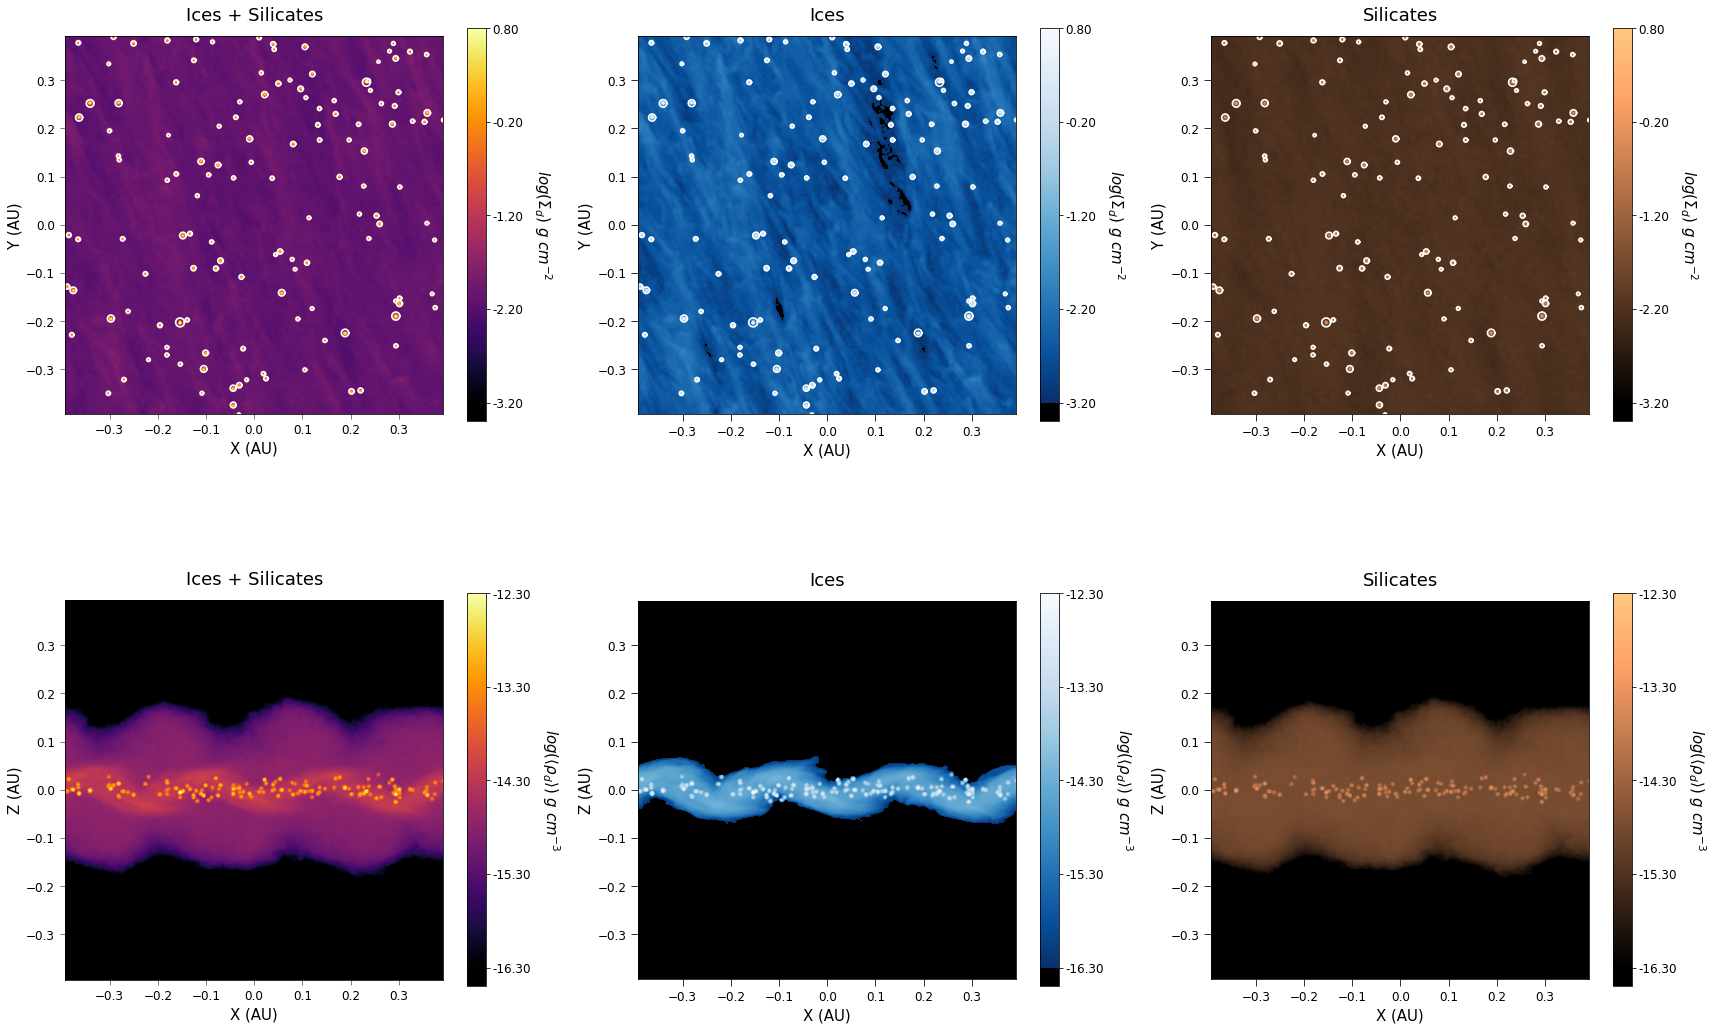

In [22]:
# Density plots for ices + silicates, ices, and silicates. xy planes are axes 1- 3 and xz planes are axes 4-6

axes = []

large = 18
medium = 15
small = 12

nrows = 2
ncols = 3

# dens_max = np.log10(np.max(ff_rhop[dim['nz'] // 2,:,:]))
dens_max = np.log10(np.max(totalx_rhop) * rho_naught * eps)
dens_min = dens_max - 4
levels = np.linspace(dens_min, dens_max, resolution * 2)
dens_max1 = np.log10(np.max(totalz_rhop) * rho_naught * eps * unit_length)
dens_min1 = dens_max1 - 4
levels1 = np.linspace(dens_min1, dens_max1, resolution * 2)
tick_pos = np.arange(dens_min,dens_max + 1,1)
tick_lab = make_string(tick_pos)

tick_pos1 = np.arange(dens_min1,dens_max1 + 1,1)
tick_lab1 = make_string(tick_pos1)

fig = plt.figure(figsize=(8 * ncols,8 * nrows))

###############################################################

ax1 = fig.add_subplot(nrows, ncols, 1)
axes.append(ax1)

ax1.set_title("Ices + Silicates",fontsize=large,pad=15)

ax1.set_aspect('equal')
im1 = ax1.contourf(ff_x, ff_z,np.log10((totalz_rhop + 1e-10) * rho_naught * eps * unit_length),levels = levels1,vmin = dens_min1,cmap='inferno',extend="min")
im1.cmap.set_under('black')
im1.changed()

ax1.set_xlabel("X (AU)",fontsize=medium)
ax1.set_ylabel("Y (AU)",fontsize=medium)

cbar1 = fig.colorbar(im1,ax=ax1,shrink=0.7, format='%.2f',extendrect=True,drawedges=False,ticks=tick_pos1)
cbar1.set_label("$log (\\Sigma_{d}) \ g \ cm^{-2}$",rotation=270,labelpad=30,fontsize=medium)
cbar1.ax.set_yticklabels(tick_lab1,fontsize=small)

ax1.tick_params(direction="out", top =False, length=5, width=0.5, labelsize = small, pad=5)

###############################################################

ax2 = fig.add_subplot(nrows, ncols, 2)
axes.append(ax2)

ax2.set_title("Ices",fontsize=large,pad=15)

ax2.set_aspect('equal')
im2 = ax2.contourf(ff_x, ff_z, np.log10((totalz_ice + 1e-10) * rho_naught * eps * unit_length),levels = levels1,vmin = dens_min1,cmap='Blues_r',extend="min")
im2.cmap.set_under('black')
im2.changed()

ax2.set_xlabel("X (AU)",fontsize=medium)
ax2.set_ylabel("Y (AU)",fontsize=medium)

cbar2 = fig.colorbar(im2,ax=ax2,shrink=0.7,extendrect=True,drawedges=False,ticks=tick_pos1)
cbar2.set_label("$log (\\Sigma_{d}) \ g \ cm^{-2}$",rotation=270,labelpad=30,fontsize=medium)
cbar2.ax.set_yticklabels(tick_lab1,fontsize=small)

ax2.tick_params(direction="out", top  =False,   length=7, width=0.8, labelsize = small, pad=5)

###############################################################

ax3 = fig.add_subplot(nrows, ncols, 3)
axes.append(ax3)

ax3.set_title("Silicates",fontsize=large,pad=15)

ax3.set_aspect('equal')
im3 = ax3.contourf(ff_x, ff_y, np.log10((totalz_sil + 1e-10) * rho_naught * eps * unit_length),levels = levels1,vmin = dens_min1,cmap='copper',extend="min")
im3.cmap.set_under('black')
im3.changed()

ax3.set_xlabel("X (AU)",fontsize=medium)
ax3.set_ylabel("Y (AU)",fontsize=medium)

cbar3 = fig.colorbar(im3,ax=ax3,shrink=0.7,extendrect=True,drawedges=False,ticks=tick_pos1)
cbar3.set_label("$log (\\Sigma_{d}) \ g \ cm^{-2}$",rotation=270,labelpad=30,fontsize=medium)
cbar3.ax.set_yticklabels(tick_lab1,fontsize=small)

ax3.tick_params(direction="out", top  =False,   length=7, width=0.8, labelsize = small, pad=5)

# ###############################################################


ax4 = fig.add_subplot(nrows, ncols, 4)
axes.append(ax4)

ax4.set_title("Ices + Silicates",fontsize=large,pad=15)

ax4.set_aspect('equal')
im4 = ax4.contourf(ff_x, ff_z,np.log10((totaly_rhop + 1e-10) * rho_naught * eps),levels = levels,vmin = dens_min,cmap='inferno',extend="min")
im4.cmap.set_under('black')
im4.changed()

ax4.set_xlabel("X (AU)",fontsize=medium)
ax4.set_ylabel("Z (AU)",fontsize=medium)

cbar4 = fig.colorbar(im4,ax=ax4,shrink=0.7, format='%.2f',extendrect=True,drawedges=False,ticks=tick_pos)
cbar4.set_label("$log (\\langle\\rho_{d}\\rangle) \ g \ cm^{-3}$",rotation=270,labelpad=30,fontsize=medium)
cbar4.ax.set_yticklabels(tick_lab,fontsize=small)

ax4.tick_params(direction="out", top  =False,   length=5, width=0.5, labelsize = small, pad=5)

###############################################################

ax5 = fig.add_subplot(nrows, ncols, 5)
axes.append(ax5)

ax5.set_title("Ices",fontsize=large,pad=15)

ax5.set_aspect('equal')
im5 = ax5.contourf(ff_x, ff_y, np.log10((totaly_ice + 1e-10) * rho_naught * eps),levels = levels,vmin = dens_min,cmap='Blues_r',extend="min")
im5.cmap.set_under('black')
im5.changed()

ax5.set_xlabel("X (AU)",fontsize=medium)
ax5.set_ylabel("Z (AU)",fontsize=medium)

cbar5 = fig.colorbar(im5,ax=ax5,shrink=0.7,extendrect=True,drawedges=False,ticks=tick_pos)
cbar5.set_label("$log (\\langle\\rho_{d}\\rangle) \ g \ cm^{-3}$",rotation=270,labelpad=30,fontsize=medium)
cbar5.ax.set_yticklabels(tick_lab,fontsize=small)

ax5.tick_params(direction="out", top  =False,   length=7, width=0.8, labelsize = small, pad=5)

###############################################################

ax6 = fig.add_subplot(nrows, ncols, 6)
axes.append(ax6)

ax6.set_title("Silicates",fontsize=large,pad=15)

ax6.set_aspect('equal')
im6 = ax6.contourf(ff_x, ff_y, np.log10((totaly_sil + 1e-10) * rho_naught * eps),levels = levels,vmin = dens_min,cmap='copper',extend="min")
im6.cmap.set_under('black')
im6.changed()

ax6.set_xlabel("X (AU)",fontsize=medium)
ax6.set_ylabel("Z (AU)",fontsize=medium)

cbar6 = fig.colorbar(im6,ax=ax6,shrink=0.7,extendrect=True,drawedges=False,ticks=tick_pos)
cbar6.set_label("$log (\\langle\\rho_{d}\\rangle) \ g \ cm^{-3}$",rotation=270,labelpad=30,fontsize=medium)
cbar6.ax.set_yticklabels(tick_lab,fontsize=small)

ax6.tick_params(direction="out", top  =False,   length=7, width=0.8, labelsize = small, pad=5)

theta = np.linspace(0, 2 * np.pi, 500)
for index, item in enumerate(hill_list):
    x_sink = item * np.cos(theta) + sink_x[index]
    y_sink = item * np.sin(theta) + sink_y[index]
    for i in list(range(len(axes))):
        if i >= 3:
            break
        axes[i].plot(x_sink,y_sink, c='w', linewidth=1.7)#D0D2DE
    
for i in list(range(len(axes))):
    if i >= 3:
        break
    axes[i].set_xlim(np.min(ff_x),np.max(ff_x))
    axes[i].set_ylim(np.min(ff_y),np.max(ff_y))


plt.tight_layout()
# plt.savefig(f'run{run}_ivar{ivar}/xyyz_all_mesh.png', dpi=500)
# plt.savefig(f'run{run}_ivar{ivar}xyyz_all_mesh.pdf', format='pdf')